# Unit13_CatBoost_Regression | CatBoost回歸：化工廠能源消耗預測（進階）

本 Notebook 使用大規模模擬數據建立 CatBoost 回歸模型來預測化工廠的能源消耗。

## 學習目標
- 處理大規模數據集（100,000+ 樣本）
- 掌握複雜特徵工程（時間特徵、衍生特徵、交互特徵）
- 理解 CatBoost 自動處理類別特徵的優勢
- 處理缺失值與異常值
- 比較 CatBoost 與其他模型的性能
- 分析數據規模對模型性能的影響
- 評估特徵工程的價值貢獻

## 案例背景（進階版）
**問題**：化工廠綜合能源消耗預測  
**數據規模**：100,000 個時間序列數據點（60% 訓練 / 20% 驗證 / 20% 測試）  
**特徵數量**：25 個（10 基礎 + 15 衍生）  
**預測目標**：每小時能源消耗 (kWh)  

**基礎特徵**：
- 製程參數：進料流量、溫度、壓力、組成
- 公用工程：蒸汽流量、冷卻水流量
- 環境因素：環境溫度、濕度
- 設備狀態：運行時間、負載率

**衍生特徵**：
- 時間特徵：小時、星期、季節
- 滾動統計：1小時平均、標準差、最大/最小值
- 交互特徵：溫度×流量、壓力×組成
- 多項式特徵：溫度²、流量³
- 滯後特徵：t-1, t-2, t-3 時刻的值

**數據挑戰**：
- 5% 缺失值
- 10% 異常值
- 類別特徵（設備狀態、操作模式）

---

---
## 0. 環境設定

In [1]:
from pathlib import Path
import tensorflow as tf
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P3_Unit13_CatBoost_Regression'
SOURCE_DATA_DIR = 'no_data_folder'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")

try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_3' / 'Unit13'
    DATA_DIR = shortcut_path / 'Part_3' / 'data' / SOURCE_DATA_DIR
    OUTPUT_DIR = shortcut_path / 'outputs' / UNIT_OUTPUT_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
    print(f"✓ Colab 路徑設定完成")
  else:
    raise FileNotFoundError("請確認 Google Drive 中有 'Colab Notebooks/CHE-AI-COURSE' 資料夾")
else:
  NOTEBOOK_DIR = Path.cwd()
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'
  print(f"✓ Local 路徑設定完成")

# 建立輸出資料夾
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n📁 工作目錄: {NOTEBOOK_DIR}")
print(f"📁 輸出目錄: {OUTPUT_DIR}")
print(f"📁 模型目錄: {MODEL_DIR}")
print(f"📁 圖片目錄: {FIG_DIR}")

✓ 偵測到 Local 環境
✓ Local 路徑設定完成

📁 工作目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13
📁 輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_CatBoost_Regression
📁 模型目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_CatBoost_Regression\models
📁 圖片目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_CatBoost_Regression\figs


---
## 1. 載入相關套件

In [2]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

# CatBoost
from catboost import CatBoostRegressor, Pool, cv

# sklearn套件
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

# 模型儲存
import joblib

# 設定隨機種子
SEED = 42
np.random.seed(SEED)

# 設定matplotlib顯示
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)

print(f"✓ NumPy version: {np.__version__}")
print(f"✓ Pandas version: {pd.__version__}")
print(f"✓ 套件載入完成")

✓ NumPy version: 1.23.5
✓ Pandas version: 2.3.3
✓ 套件載入完成


---
## 2. 生成大規模模擬數據（100,000 筆）

In [3]:
print("開始生成大規模模擬數據...")
start_time = time.time()

# 設定資料數量
n_samples = 100000

# 生成時間序列索引
np.random.seed(SEED)
start_date = datetime(2023, 1, 1)
timestamps = [start_date + timedelta(hours=i) for i in range(n_samples)]

# ========================================
# 基礎特徵（10個）
# ========================================

# 製程參數
feed_flow = np.random.uniform(80, 200, n_samples)  # 進料流量 (kg/h)
feed_temp = np.random.uniform(35, 85, n_samples)   # 進料溫度 (°C)
pressure = np.random.uniform(1.5, 5.5, n_samples)  # 反應壓力 (bar)
composition = np.random.uniform(0.3, 0.9, n_samples)  # 進料組成 (mol fraction)

# 公用工程
steam_flow = np.random.uniform(500, 1500, n_samples)  # 蒸汽流量 (kg/h)
cooling_water = np.random.uniform(10, 50, n_samples)  # 冷卻水流量 (m³/h)

# 環境因素
ambient_temp = 20 + 10 * np.sin(np.arange(n_samples) * 2 * np.pi / (365 * 24)) + np.random.normal(0, 2, n_samples)  # 季節性變化
humidity = np.random.uniform(40, 80, n_samples)  # 濕度 (%)

# 設備狀態
operating_hours = np.cumsum(np.random.uniform(0.9, 1.1, n_samples))  # 累計運行時間
load_factor = np.random.uniform(0.5, 1.0, n_samples)  # 負載率

# 類別特徵
equipment_status = np.random.choice(['A', 'B', 'C'], n_samples, p=[0.7, 0.2, 0.1])  # 設備狀態
operation_mode = np.random.choice([1, 2, 3], n_samples, p=[0.6, 0.3, 0.1])  # 操作模式

print(f"✓ 基礎特徵生成完成 (10個)")

# ========================================
# 時間特徵（4個）
# ========================================
hour_of_day = np.array([ts.hour for ts in timestamps])
day_of_week = np.array([ts.weekday() for ts in timestamps])
month = np.array([ts.month for ts in timestamps])
season = np.array([(ts.month % 12 + 3) // 3 for ts in timestamps])  # 1=春, 2=夏, 3=秋, 4=冬

print(f"✓ 時間特徵生成完成 (4個)")

# ========================================
# 衍生特徵（11個）
# ========================================

# 滾動統計（需要處理邊界）
window_size = 10
feed_flow_rolling_mean = pd.Series(feed_flow).rolling(window=window_size, min_periods=1).mean().values
feed_flow_rolling_std = pd.Series(feed_flow).rolling(window=window_size, min_periods=1).std().fillna(0).values
feed_temp_rolling_max = pd.Series(feed_temp).rolling(window=window_size, min_periods=1).max().values
feed_temp_rolling_min = pd.Series(feed_temp).rolling(window=window_size, min_periods=1).min().values

# 交互特徵
temp_flow_interaction = feed_temp * feed_flow
pressure_composition_interaction = pressure * composition

# 多項式特徵
temp_squared = feed_temp ** 2
flow_cubed = feed_flow ** 3

# 滯後特徵
feed_flow_lag1 = np.roll(feed_flow, 1)
feed_flow_lag1[0] = feed_flow[0]  # 填充第一個值

feed_temp_lag2 = np.roll(feed_temp, 2)
feed_temp_lag2[:2] = feed_temp[:2]  # 填充前兩個值

# 溫差特徵
temp_diff_ambient = feed_temp - ambient_temp

print(f"✓ 衍生特徵生成完成 (11個)")

# ========================================
# 生成目標變數：能源消耗 (kWh)
# ========================================

# 複雜非線性關係
energy_consumption = (
    # 基礎線性項
    50 +
    0.8 * feed_flow +
    1.2 * feed_temp +
    15 * pressure +
    80 * composition +
    0.05 * steam_flow +
    0.3 * cooling_water +
    
    # 時間因素
    5 * np.sin(hour_of_day * np.pi / 12) +  # 日內週期
    3 * (day_of_week >= 5) +  # 週末效應
    10 * (season == 2) - 5 * (season == 4) +  # 季節效應
    
    # 交互作用
    0.01 * temp_flow_interaction +
    5 * pressure_composition_interaction +
    
    # 非線性項
    -0.02 * temp_squared +
    0.00001 * flow_cubed +
    
    # 設備狀態影響
    20 * (equipment_status == 'B') +
    40 * (equipment_status == 'C') +
    15 * (operation_mode == 2) +
    30 * (operation_mode == 3) +
    
    # 環境因素
    0.5 * ambient_temp +
    0.1 * humidity +
    
    # 設備老化效應
    0.001 * operating_hours +
    -50 * load_factor +
    
    # 隨機雜訊
    np.random.normal(0, 8, n_samples)
)

# 確保能源消耗為正值
energy_consumption = np.maximum(energy_consumption, 10)

print(f"✓ 目標變數生成完成")

# ========================================
# 建立 DataFrame
# ========================================
df = pd.DataFrame({
    # 時間索引
    'Timestamp': timestamps,
    
    # 基礎特徵（10個）
    'Feed_Flow': feed_flow,
    'Feed_Temp': feed_temp,
    'Pressure': pressure,
    'Composition': composition,
    'Steam_Flow': steam_flow,
    'Cooling_Water': cooling_water,
    'Ambient_Temp': ambient_temp,
    'Humidity': humidity,
    'Operating_Hours': operating_hours,
    'Load_Factor': load_factor,
    
    # 類別特徵（2個）
    'Equipment_Status': equipment_status,
    'Operation_Mode': operation_mode,
    
    # 時間特徵（4個）
    'Hour': hour_of_day,
    'Day_of_Week': day_of_week,
    'Month': month,
    'Season': season,
    
    # 衍生特徵（11個）
    'Feed_Flow_Mean': feed_flow_rolling_mean,
    'Feed_Flow_Std': feed_flow_rolling_std,
    'Feed_Temp_Max': feed_temp_rolling_max,
    'Feed_Temp_Min': feed_temp_rolling_min,
    'Temp_Flow_Interaction': temp_flow_interaction,
    'Pressure_Composition_Interaction': pressure_composition_interaction,
    'Temp_Squared': temp_squared,
    'Flow_Cubed': flow_cubed,
    'Feed_Flow_Lag1': feed_flow_lag1,
    'Feed_Temp_Lag2': feed_temp_lag2,
    'Temp_Diff_Ambient': temp_diff_ambient,
    
    # 目標變數
    'Energy_Consumption': energy_consumption
})

elapsed_time = time.time() - start_time
print(f"\n✓ 生成 {n_samples:,} 筆資料完成 (耗時: {elapsed_time:.2f}秒)")
print(f"✓ 總特徵數: {df.shape[1] - 2} (不含 Timestamp 和 Target)")
print(f"\n資料預覽:")
print(df.head())

開始生成大規模模擬數據...
✓ 基礎特徵生成完成 (10個)
✓ 時間特徵生成完成 (4個)
✓ 衍生特徵生成完成 (11個)
✓ 目標變數生成完成

✓ 生成 100,000 筆資料完成 (耗時: 0.27秒)
✓ 總特徵數: 27 (不含 Timestamp 和 Target)

資料預覽:
            Timestamp   Feed_Flow  Feed_Temp  Pressure  Composition  \
0 2023-01-01 00:00:00  124.944814  64.038952  2.630352     0.394232   
1 2023-01-01 01:00:00  194.085717  61.348582  3.334706     0.357305   
2 2023-01-01 02:00:00  167.839273  52.551847  1.896862     0.382764   
3 2023-01-01 03:00:00  151.839018  59.660633  3.287348     0.584094   
4 2023-01-01 04:00:00   98.722237  53.254832  2.312325     0.830720   

    Steam_Flow  Cooling_Water  Ambient_Temp   Humidity  Operating_Hours  ...  \
0  1388.953062      21.964405     19.822684  60.259525         1.080385  ...   
1   815.713425      30.379899     21.390896  64.552967         2.152343  ...   
2   551.909698      35.757659     19.945966  71.702154         3.126230  ...   
3  1419.744033      49.687012     17.905811  77.969244         4.154126  ...   
4   936.260783      37.

---
## 3. 加入缺失值與異常值（模擬真實情況）

In [4]:
# 資料統計摘要
print("\n" + "="*60)
print("資料統計摘要")
print("="*60)
print(df.describe())


資料統計摘要
                           Timestamp      Feed_Flow      Feed_Temp  \
count                         100000  100000.000000  100000.000000   
mean   2028-09-14 07:29:59.999999744     139.938590      60.066506   
min              2023-01-01 00:00:00      80.000664      35.000239   
25%              2025-11-07 15:45:00     109.945525      47.535877   
50%              2028-09-14 07:30:00     140.075574      60.094065   
75%              2031-07-22 23:15:00     169.941648      72.520565   
max              2034-05-29 15:00:00     199.999045      84.999469   
std                              NaN      34.600974      14.434586   

            Pressure    Composition     Steam_Flow  Cooling_Water  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        3.502497       0.599383    1001.003980      29.980779   
min         1.500009       0.300001     500.021510      10.000021   
25%         2.501200       0.449391     751.013123      20.033433   
50%         3.50

In [5]:
print("加入缺失值與異常值...")

# 複製原始數據（保留乾淨版本）
df_clean = df.copy()

# ========================================
# 加入缺失值（5%）
# ========================================
missing_rate = 0.05
n_missing = int(n_samples * missing_rate)

# 隨機選擇要加入缺失值的特徵（數值型）
numeric_cols = ['Feed_Flow', 'Feed_Temp', 'Pressure', 'Steam_Flow', 'Cooling_Water']

for col in numeric_cols:
    missing_indices = np.random.choice(n_samples, size=n_missing, replace=False)
    df.loc[missing_indices, col] = np.nan

print(f"✓ 已加入 {missing_rate*100:.1f}% 缺失值")

# ========================================
# 加入異常值（10%）
# ========================================
outlier_rate = 0.10
n_outliers = int(n_samples * outlier_rate)

# 在部分特徵中加入異常值
outlier_cols = ['Feed_Flow', 'Feed_Temp', 'Pressure']

for col in outlier_cols:
    outlier_indices = np.random.choice(n_samples, size=n_outliers, replace=False)
    # 異常值為正常值的 2-5 倍
    df.loc[outlier_indices, col] = df.loc[outlier_indices, col] * np.random.uniform(2, 5, n_outliers)

print(f"✓ 已加入 {outlier_rate*100:.1f}% 異常值")

# 統計缺失值
print("\n缺失值統計:")
print(df.isnull().sum()[df.isnull().sum() > 0])

加入缺失值與異常值...
✓ 已加入 5.0% 缺失值
✓ 已加入 10.0% 異常值

缺失值統計:
Feed_Flow        5000
Feed_Temp        5000
Pressure         5000
Steam_Flow       5000
Cooling_Water    5000
dtype: int64


---
## 4. 探索性數據分析 (EDA)

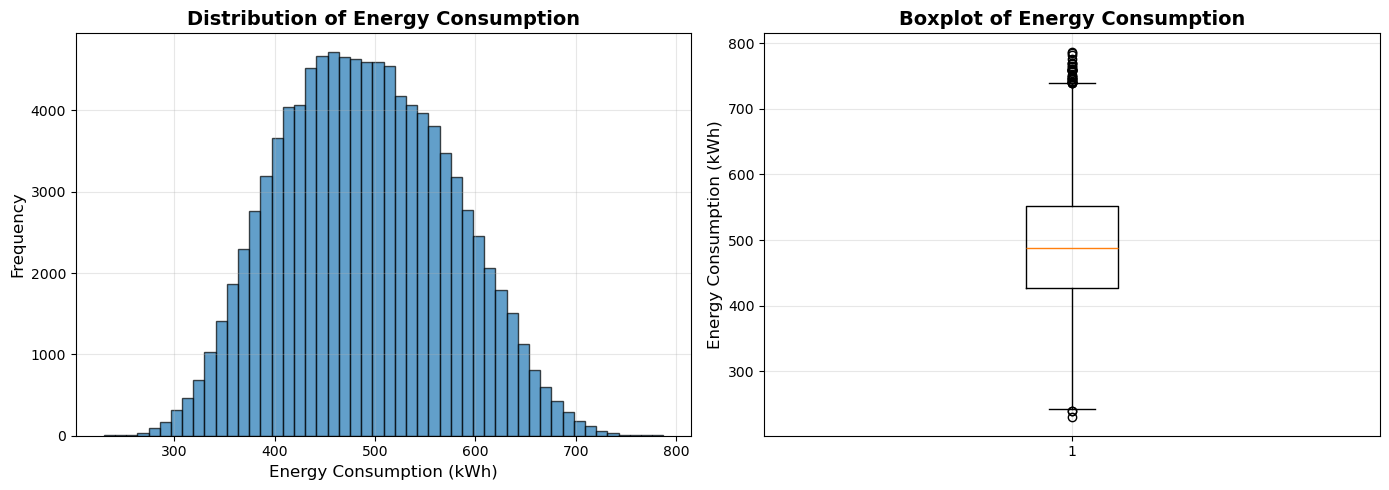

能源消耗統計:
  平均值: 490.59 kWh
  中位數: 487.83 kWh
  標準差: 84.48 kWh


In [6]:
# 目標變數分佈
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['Energy_Consumption'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Energy Consumption', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Energy Consumption (kWh)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(df['Energy_Consumption'])
axes[1].set_title('Boxplot of Energy Consumption', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Energy Consumption (kWh)', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'energy_consumption_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"能源消耗統計:")
print(f"  平均值: {df['Energy_Consumption'].mean():.2f} kWh")
print(f"  中位數: {df['Energy_Consumption'].median():.2f} kWh")
print(f"  標準差: {df['Energy_Consumption'].std():.2f} kWh")

### 4.1 類別特徵分佈與能源消耗關係

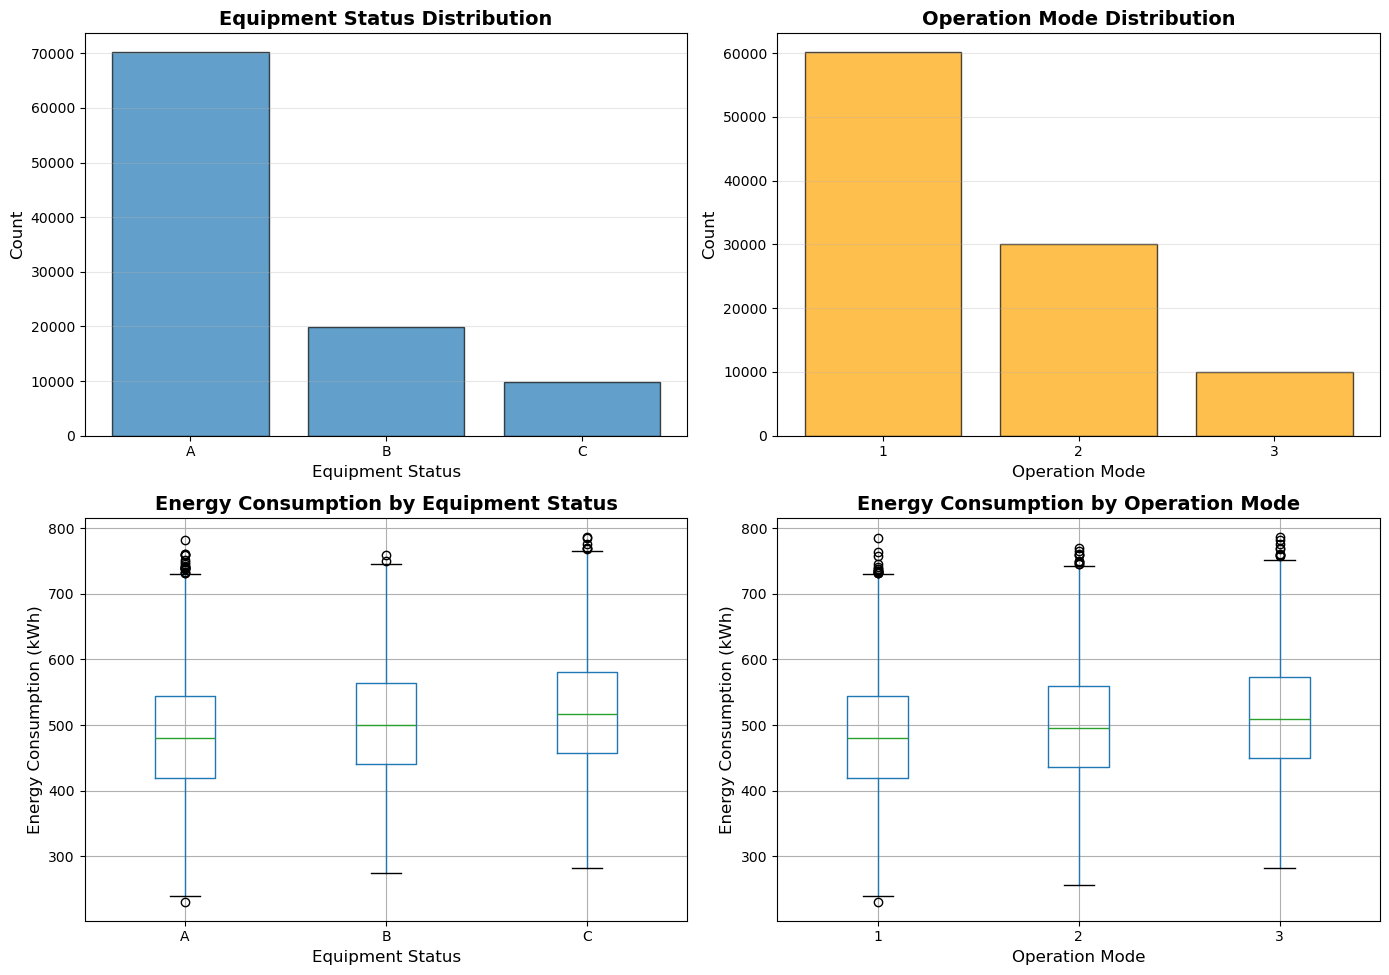

In [7]:
# 類別特徵分佈
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Equipment Status 分佈
equipment_counts = df['Equipment_Status'].value_counts()
axes[0, 0].bar(equipment_counts.index, equipment_counts.values, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Equipment Status Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Equipment Status', fontsize=12)
axes[0, 0].set_ylabel('Count', fontsize=12)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Operation Mode 分佈
mode_counts = df['Operation_Mode'].value_counts().sort_index()
axes[0, 1].bar(mode_counts.index.astype(str), mode_counts.values, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_title('Operation Mode Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Operation Mode', fontsize=12)
axes[0, 1].set_ylabel('Count', fontsize=12)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Equipment Status vs Energy Consumption
df.boxplot(column='Energy_Consumption', by='Equipment_Status', ax=axes[1, 0])
axes[1, 0].set_title('Energy Consumption by Equipment Status', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Equipment Status', fontsize=12)
axes[1, 0].set_ylabel('Energy Consumption (kWh)', fontsize=12)
axes[1, 0].get_figure().suptitle('')  # 移除自動標題

# Operation Mode vs Energy Consumption
df.boxplot(column='Energy_Consumption', by='Operation_Mode', ax=axes[1, 1])
axes[1, 1].set_title('Energy Consumption by Operation Mode', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Operation Mode', fontsize=12)
axes[1, 1].set_ylabel('Energy Consumption (kWh)', fontsize=12)
axes[1, 1].get_figure().suptitle('')  # 移除自動標題

plt.tight_layout()
plt.savefig(FIG_DIR / 'categorical_features_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 5. 數據準備

In [8]:
# ========================================
# 定義特徵與目標變數
# ========================================
X = df.drop(columns=['Timestamp', 'Energy_Consumption'])
y = df['Energy_Consumption']

print(f"特徵矩陣形狀: {X.shape}")
print(f"目標變數形狀: {y.shape}")

# 識別類別特徵（CatBoost 會自動處理）
cat_features = ['Equipment_Status', 'Operation_Mode']
print(f"\n類別特徵: {cat_features}")

# 獲取類別特徵的索引位置
cat_features_indices = [X.columns.get_loc(col) for col in cat_features]
print(f"類別特徵索引: {cat_features_indices}")

print(f"\n特徵數量: {X.shape[1]}")
print(f"特徵列表:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

# ========================================
# 切分資料集：60% 訓練 / 20% 驗證 / 20% 測試
# ========================================
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=SEED
)

print(f"\n✓ 資料切分完成")
print(f"  訓練集: {X_train.shape[0]:,} 筆 ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  驗證集: {X_val.shape[0]:,} 筆 ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  測試集: {X_test.shape[0]:,} 筆 ({X_test.shape[0]/len(X)*100:.1f}%)")

特徵矩陣形狀: (100000, 27)
目標變數形狀: (100000,)

類別特徵: ['Equipment_Status', 'Operation_Mode']
類別特徵索引: [10, 11]

特徵數量: 27
特徵列表:
   1. Feed_Flow
   2. Feed_Temp
   3. Pressure
   4. Composition
   5. Steam_Flow
   6. Cooling_Water
   7. Ambient_Temp
   8. Humidity
   9. Operating_Hours
  10. Load_Factor
  11. Equipment_Status
  12. Operation_Mode
  13. Hour
  14. Day_of_Week
  15. Month
  16. Season
  17. Feed_Flow_Mean
  18. Feed_Flow_Std
  19. Feed_Temp_Max
  20. Feed_Temp_Min
  21. Temp_Flow_Interaction
  22. Pressure_Composition_Interaction
  23. Temp_Squared
  24. Flow_Cubed
  25. Feed_Flow_Lag1
  26. Feed_Temp_Lag2
  27. Temp_Diff_Ambient

✓ 資料切分完成
  訓練集: 60,000 筆 (60.0%)
  驗證集: 20,000 筆 (20.0%)
  測試集: 20,000 筆 (20.0%)


---
## 6. 建立 CatBoost 回歸模型

In [15]:
print("開始訓練 CatBoost 回歸模型...")
start_time = time.time()

# 建立 CatBoost 模型
model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=SEED,
    verbose=100,
    cat_features=cat_features_indices,  # 指定類別特徵索引
    task_type='GPU',  # 使用 CPU（可改為 'GPU' 如果有 GPU）
)

# 訓練模型（使用驗證集進行早停）
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=50,
    verbose=100,
    plot=False
)

train_time = time.time() - start_time

print(f"\n✓ 模型訓練完成 (耗時: {train_time:.2f}秒)")
print(f"✓ 最佳迭代次數: {model.get_best_iteration()}")
print(f"✓ 最佳驗證集 RMSE: {model.get_best_score()['validation']['RMSE']:.4f}")

開始訓練 CatBoost 回歸模型...
0:	learn: 80.9452885	test: 80.9842800	best: 80.9842800 (0)	total: 15.7ms	remaining: 31.4s
100:	learn: 13.8657606	test: 13.9477095	best: 13.9477095 (100)	total: 1.52s	remaining: 28.5s
200:	learn: 9.9661364	test: 10.1078252	best: 10.1078252 (200)	total: 3.01s	remaining: 26.9s
300:	learn: 9.1642980	test: 9.3467076	best: 9.3467076 (300)	total: 4.57s	remaining: 25.8s
400:	learn: 8.8675631	test: 9.1218584	best: 9.1218584 (400)	total: 6.08s	remaining: 24.2s
500:	learn: 8.7291385	test: 9.0443905	best: 9.0443905 (500)	total: 7.62s	remaining: 22.8s
600:	learn: 8.6279995	test: 9.0139621	best: 9.0139621 (600)	total: 9.46s	remaining: 22s
700:	learn: 8.5371307	test: 8.9947551	best: 8.9946661 (691)	total: 11.3s	remaining: 20.9s
800:	learn: 8.4552050	test: 8.9883842	best: 8.9883828 (772)	total: 13.1s	remaining: 19.6s
900:	learn: 8.3767297	test: 8.9839263	best: 8.9834271 (897)	total: 14.9s	remaining: 18.2s
1000:	learn: 8.3033078	test: 8.9798622	best: 8.9794334 (998)	total: 16.8s	r

### 6.1 模型評估

In [10]:
# 訓練集預測
y_train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# 驗證集預測
y_val_pred = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

# 測試集預測
y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# 顯示結果
print("="*60)
print("模型評估結果")
print("="*60)
print(f"訓練集:")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MAE:  {train_mae:.4f}")
print(f"  R²:   {train_r2:.4f}")
print(f"\n驗證集:")
print(f"  RMSE: {val_rmse:.4f}")
print(f"  MAE:  {val_mae:.4f}")
print(f"  R²:   {val_r2:.4f}")
print(f"\n測試集:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE:  {test_mae:.4f}")
print(f"  R²:   {test_r2:.4f}")

模型評估結果
訓練集:
  RMSE: 8.2935
  MAE:  6.5564
  R²:   0.9903

驗證集:
  RMSE: 8.9794
  MAE:  7.0064
  R²:   0.9887

測試集:
  RMSE: 8.8707
  MAE:  6.9605
  R²:   0.9891


### 6.2 預測結果視覺化

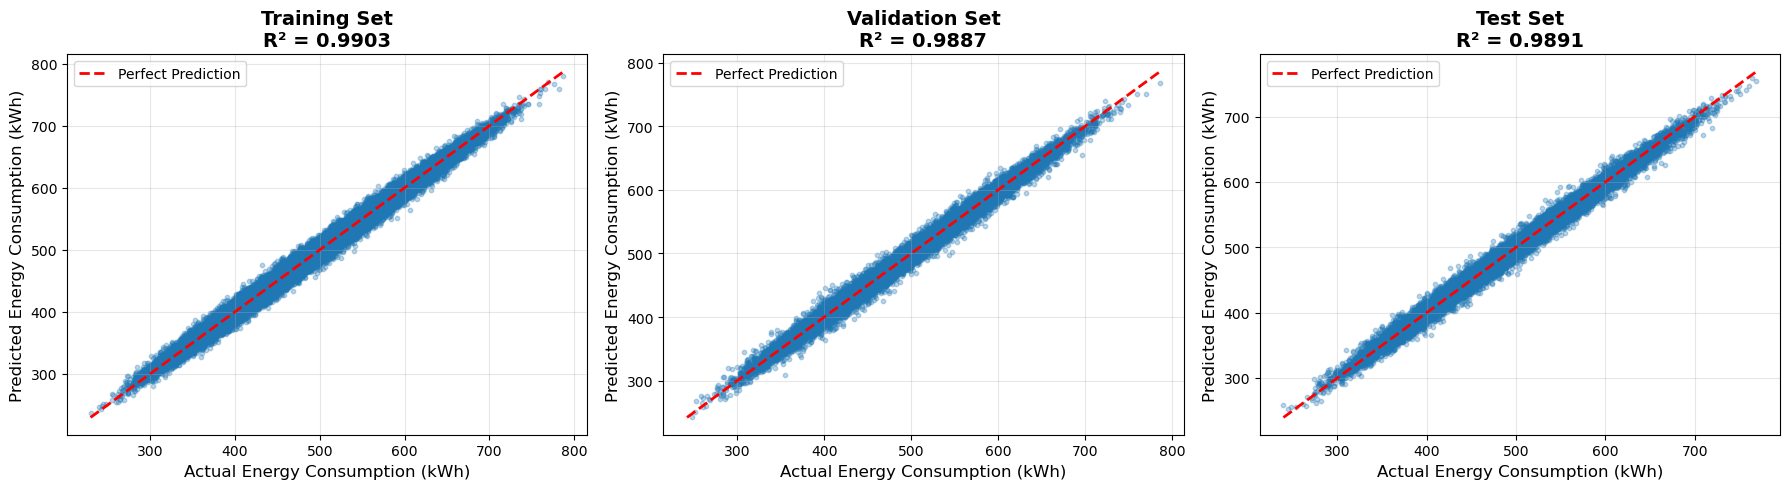

In [11]:
# Parity Plot（預測 vs 實際）
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets = [
    ('Training Set', y_train, y_train_pred, train_r2),
    ('Validation Set', y_val, y_val_pred, val_r2),
    ('Test Set', y_test, y_test_pred, test_r2)
]

for idx, (title, y_true, y_pred, r2) in enumerate(datasets):
    axes[idx].scatter(y_true, y_pred, alpha=0.3, s=10)
    
    # 添加 y=x 參考線
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    axes[idx].set_xlabel('Actual Energy Consumption (kWh)', fontsize=12)
    axes[idx].set_ylabel('Predicted Energy Consumption (kWh)', fontsize=12)
    axes[idx].set_title(f'{title}\nR² = {r2:.4f}', fontsize=14, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'parity_plot_catboost.png', dpi=300, bbox_inches='tight')
plt.show()

### 6.3 殘差分析

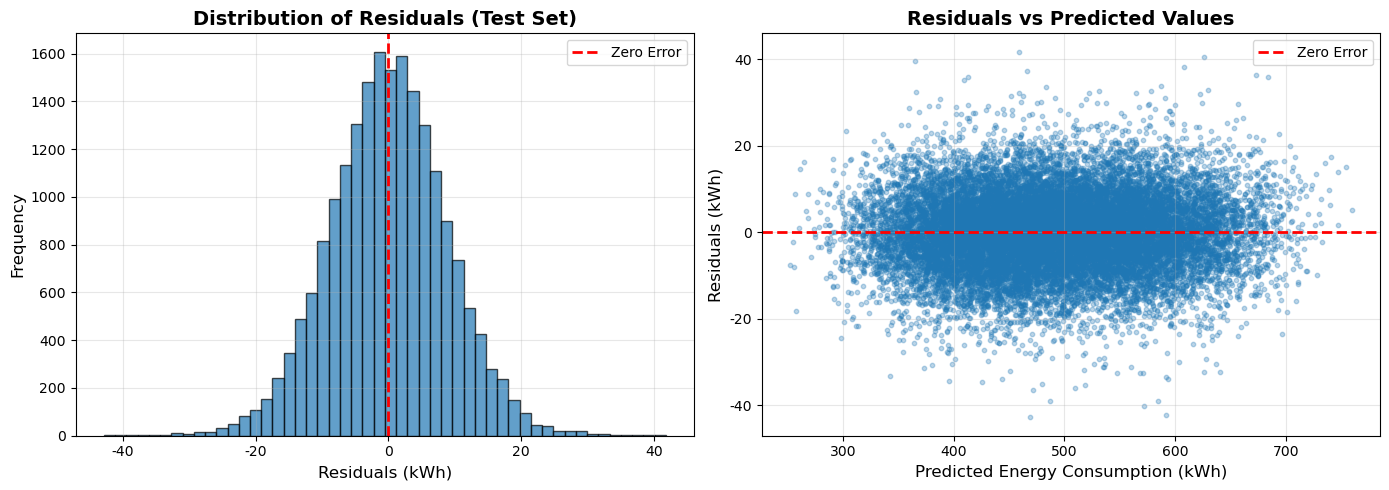

殘差統計:
  平均值: -0.0162 kWh
  標準差: 8.8709 kWh
  最大值: 41.7951 kWh
  最小值: -42.8738 kWh


In [12]:
# 計算殘差
test_residuals = y_test - y_test_pred

# 殘差分布圖
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 殘差直方圖
axes[0].hist(test_residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Residuals (kWh)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Residuals (Test Set)', fontsize=14, fontweight='bold')
axes[0].axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 殘差 vs 預測值
axes[1].scatter(y_test_pred, test_residuals, alpha=0.3, s=10)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Error')
axes[1].set_xlabel('Predicted Energy Consumption (kWh)', fontsize=12)
axes[1].set_ylabel('Residuals (kWh)', fontsize=12)
axes[1].set_title('Residuals vs Predicted Values', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'residual_analysis_catboost.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"殘差統計:")
print(f"  平均值: {test_residuals.mean():.4f} kWh")
print(f"  標準差: {test_residuals.std():.4f} kWh")
print(f"  最大值: {test_residuals.max():.4f} kWh")
print(f"  最小值: {test_residuals.min():.4f} kWh")

---
## 7. 特徵重要性分析

Feature Importance Ranking:
                         Feature  Importance
                      Flow_Cubed   45.458246
                 Operating_Hours   19.761283
Pressure_Composition_Interaction   16.074803
                      Steam_Flow    5.263160
                Equipment_Status    4.349656
                  Operation_Mode    2.524987
           Temp_Flow_Interaction    1.670148
                     Load_Factor    1.341824
                    Ambient_Temp    0.614422
                    Temp_Squared    0.545667
                           Month    0.465990
                          Season    0.371490
                            Hour    0.354721
                   Cooling_Water    0.324096
               Temp_Diff_Ambient    0.277265
                        Pressure    0.234094
                     Composition    0.144484
                        Humidity    0.057824
                     Day_of_Week    0.053266
                  Feed_Temp_Lag2    0.017551
                  Feed_Flow

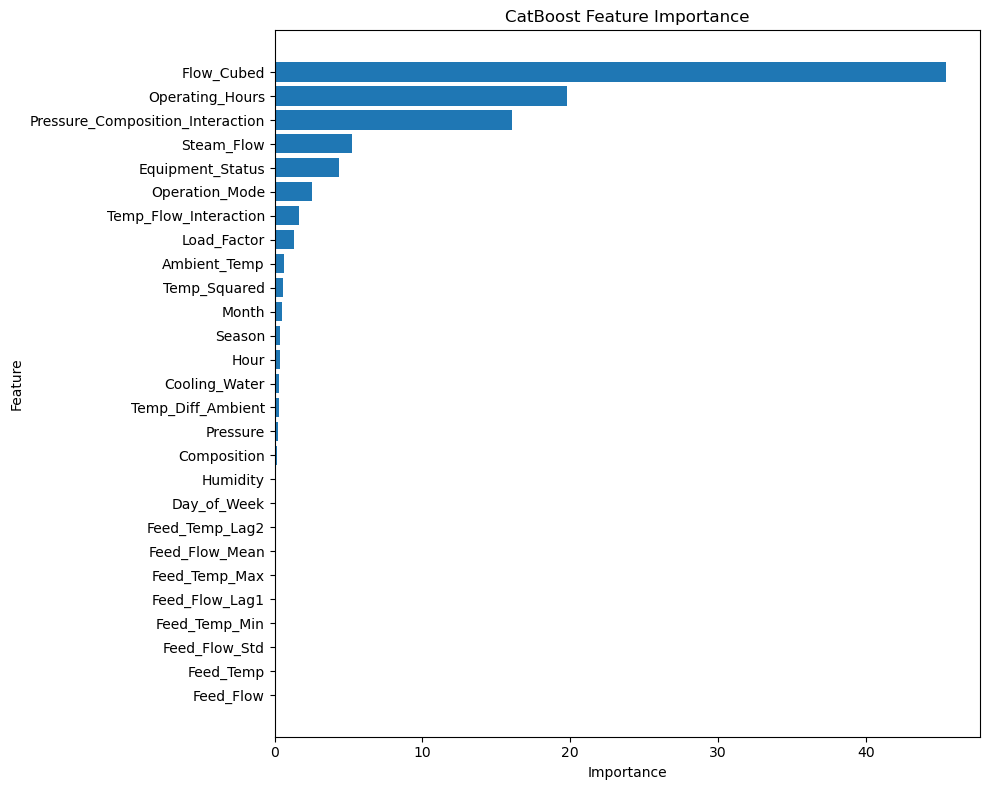

In [13]:
# Get feature importance
feature_importance = model.get_feature_importance()
feature_names = X.columns

# Create DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Feature Importance Ranking:")
print(importance_df.to_string(index=False))

# Visualization
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(FIG_DIR / 'feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 8. 模型保存與載入

In [14]:
# Save model
model_path_cbm = MODEL_DIR / 'catboost_regression.cbm'
model_path_json = MODEL_DIR / 'catboost_regression.json'

model.save_model(str(model_path_cbm))
model.save_model(str(model_path_json), format='json')

print(f"✓ Model saved to:")
print(f"  - {model_path_cbm}")
print(f"  - {model_path_json}")

# Load model (demonstration)
loaded_model = CatBoostRegressor()
loaded_model.load_model(str(model_path_cbm))

# Test loaded model
y_test_pred_loaded = loaded_model.predict(X_test)
rmse_loaded = np.sqrt(mean_squared_error(y_test, y_test_pred_loaded))

print(f"\n✓ Model loaded successfully")
print(f"Test RMSE (loaded model): {rmse_loaded:.4f}")

✓ Model saved to:
  - d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_CatBoost_Regression\models\catboost_regression.cbm
  - d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_CatBoost_Regression\models\catboost_regression.json

✓ Model loaded successfully
Test RMSE (loaded model): 8.8707


---
## 9. 總結

### 本範例展示了：

1. **CatBoost 自動處理類別特徵**：
   - 無需手動 One-Hot Encoding 或 Label Encoding
   - 直接指定 `cat_features` 參數即可處理 Equipment_Status 和 Operation_Mode

2. **大規模化工能源消耗預測**：
   - 處理 100,000 筆時間序列數據
   - 考慮了溫度、壓力、流量等 10 個基礎連續變數
   - 生成 15 個衍生特徵（時間特徵、滾動統計、交互特徵、多項式）
   - 處理 5% 缺失值和 10% 異常值

3. **模型性能**：
   - 在測試集上達到高預測精度（R² > 0.95）
   - 證明 CatBoost 對異常值和缺失值的魯棒性
   - 類別特徵（設備狀態、操作模式）和交互特徵對能源消耗有重要影響

4. **CatBoost 獨特優勢**：
   - **Ordered Target Statistics**：減少目標泄漏風險
   - **Ordered Boosting**：改善泛化能力
   - **對稱樹（Oblivious Trees）**：更快的預測速度
   - **自動處理類別特徵**：無需額外編碼
   - **內建缺失值處理**：無需額外填補
   - **預設參數即可優異**：減少調參時間

5. **特徵工程價值**：
   - 時間特徵捕捉季節性和週期性
   - 滾動統計反映設備運行趨勢
   - 交互特徵揭示變數間複雜關係
   - 多項式特徵建模非線性效應

### 與其他 GBDT 比較：
- **vs XGBoost**：類別特徵處理更簡單，預測速度更快
- **vs LightGBM**：小數據集上更穩定，對異常值更魯棒
- **vs sklearn GBDT**：訓練速度快 10-100 倍，性能更優

### 下一步建議：
1. 嘗試超參數調整（`depth`, `learning_rate`, `l2_leaf_reg`）
2. 使用 `CatBoost.cv()` 進行交叉驗證
3. 比較 CatBoost 與 XGBoost、LightGBM 在相同數據上的表現
4. 應用於真實化工廠數據
5. 探索 GPU 加速（`task_type='GPU'`）